<a id="top"></a>
# Generating Cubes and Cutouts from TESS FFIs
***
## Learning Goals

By the end of this tutorial, you will:

- Learn about the two TESS full frame image (FFI) types: SPOC and TICA.
- Learn the structure of a TICA FFI.
- Learn how to retrieve and download TESS FFIs using `astroquery.mast.Observations`.
- Learn how to generate cubes from TESS FFIs with astrocut's `CubeFactory` and `TicaCubeFactory`.
- Learn how to generate cutouts from TESS cubes with astrocut's `CutoutFactory`.
- Learn the structure of a TESS target pixel file (TPF), and therefore an astrocut cutouts file, and how to retrieve and plot the data stored within.

## Introduction

In this tutorial, you will learn the basic functionality of [astrocut](https://github.com/spacetelescope/astrocut)'s `CubeFactory`, `TicaCubeFactory`, and `CutoutFactory`. These 3 tools allow users to generate cubes and cutouts of TESS images. TESS image cubes are stacks of TESS full frame images (TESS FFIs) which are formatted to allow users to make cutouts with `CutoutFactory`. These cutouts are sub-images that will only contain your region of interest, to make analysis easier.

The process of generating cubes, and making cutouts from them, mimicks the web-based [TESSCut](https://mast.stsci.edu/tesscut/) service. This tutorial will teach you to make cubes and cutouts that are customized for your specific use-cases, while also giving insight to how TESSCut calls upon astrocut to create cutouts.

As in the TESSCut service, there are _two_ different TESS FFI product types you can work with in this notebook. These two product types are the TESS mission-provided, [Science Processing Operations Center (SPOC) FFIs](https://archive.stsci.edu/missions-and-data/tess), and the [TESS Image CAlibrator (TICA) FFIs](https://archive.stsci.edu/hlsp/tica). Both are available via `astroquery.mast.Observations`, and both have different use-cases. The TICA products offer the latest sector observations due to their faster delivery cadence, and can be available up to 3 times sooner than their SPOC counterparts. As such, for those who are working with time-sensitive observations, TICA may be the best option for generating your cutouts. Note that the SPOC and TICA products are processed through different pipelines and thus have different pixel values and WCS solutions. Please refer to the [SPOC pipeline paper](https://ui.adsabs.harvard.edu/abs/2016SPIE.9913E..3EJ/abstract) and the [TICA pipeline paper](https://iopscience.iop.org/article/10.3847/2515-5172/abd63a) for more information on the differences and similarities between the SPOC and TICA products.

![TICA and SPOC ingest](./tica-spoc-ingest.png)

The workflow for this notebook consists of:
* [Retrieving and Downloading the FFIs](#Retrieving-and-Downloading-the-FFIs)
    * [Retrieving the FFIs](#Retrieving-the-FFIs)
    * [Downloading the FFIs](#Downloading-the-FFIs)
    * [Inspecting the FFIs](#Inspecting-the-FFIs)
* [Creating a Cube](#Creating-a-Cube)
* [Creating the Cutouts](#Creating-the-Cutouts)
* [Exercise: Generate Cutouts for TIC 2527981 Sector 27 SPOC Products](#Exercise:-Generate-Cutouts-for-TIC-2527981-Sector-27-SPOC-Products)
* [Resources](#Resources)

## Imports
Below is a list of the packages used throughout this notebook, and their use-cases. Please ensure you have the recommended version of these packages installed on the environment this notebook has been launched in. See the `requirements.txt` file for recommended package versions.

- *astropy.units* for unit conversion
- *matplotlib.pyplot* for plotting data
- *numpy* to handle array functions
- *astrocut CubeFactory* for generating cubes out of TESS-SPOC FFIs
- *astrocut TicaCubeFactory* for generating cubes out of TICA FFIs
- *astrocut CutoutFactory* for generating cutouts out of astrocut cubes
- *astropy.coordinates SkyCoord* for creating sky coordinate objects
- *astropy.io fits* for accessing FITS files
- *astroquery.mast Observations* for retrieving and downloading the TESS FFIs
- *matplotlib.path Path* to generate a drawing path for plotting purposes
- *matplotlib.patches PathPatch* to generate a patch that represents the CCD footprint for plotting purposes 

In [1]:
%matplotlib inline

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astrocut import TicaCubeFactory, CutoutFactory
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astroquery.mast import Observations
from matplotlib.path import Path
from matplotlib.patches import PathPatch

Below are the helper functions we will call for plotting purposes later in the notebook.

In [2]:
def convert_coords(ra, dec):
    """ Wrap the input coordinates `ra` and `dec` around the upper limit of 180
    degrees and convert to radians so that they may be plotted on the Aitoff canvas.
    
    Parameter(s)
    -----------
    ra : str, int, or float
        The Right Ascension your target lands on, in degrees. May be any object type that 
        can be converted to a float, such as a string, or integer.
    dec : str, int, or float
        The Declination your target lands on, in degrees. May be any object type that 
        can be converted to a float, such as a string, or integer.
        
    Returns
    -------
    ra_rad : float
        The Right Ascension of your target in radians.
    dec_rad : float
        The Declination of your target in radians.
    """

    # Make a SkyCoord object out of the RA, Dec
    c = SkyCoord(ra=float(ra)*u.degree, dec=float(dec)*u.degree, frame='icrs')

    # The plotting only works when the coordinates are in radians.
    # And because it's an aitoff projection, we can't 
    # go beyond 180 degrees, so let's wrap the RA vals around that upper limit.
    ra_rad = c.ra.wrap_at(180 * u.deg).radian
    dec_rad = c.dec.radian

    return ra_rad, dec_rad


def plot_footprint(coords):
    """ Plots a polygon of 4 vertices onto an aitoff projection on a matplotlib canvas.
    
    Parameter(s)
    -----------
    coords : list or array of tuples
        An iterable object (can be a list or array) of 5 tuples, each tuple containing the 
        RA and Dec (float objects) of a vertice of your footprint. There MUST be 5: 1 for each
        vertice, and 1 to return to the starting point, as PathPatch works with a set of drawing 
        instructions, rather than a predetermined shape.
        
    Returns
    -------
    ax : Matplotlib.pyplot figure object subplot
        The subplot that contains the aitoff projection and footprint drawing.
    """
    
    assert len(coords) == 5, 'We need 5 sets of coordinates. 1 for each vertice + 1 to return to the starting point.'
    instructions = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
    
    # Create the path patch using the `coords` list of tuples and the
    # instructions from above
    c = np.array(coords)
    path = Path(c, instructions)
    ppatch = PathPatch(path, edgecolor='k', facecolor='salmon')

    # Create a matplotlib canvas
    plt.figure(figsize=(12, 12))
    
    # We will be using the `aitoff` projection for a globe canvas
    ax = plt.subplot(111, projection='aitoff')
    
    # Need grids!
    ax.grid()
    
    # Add the patch to your canvas
    ax.add_patch(ppatch)
    
    return ax

***

## Retrieving and Downloading the FFIs

Before we begin generating cubes and cutouts from TESS FFIs, we must first acquire these FFIs. To do this, we will request and download the FFIs locally using [astroquery.mast](https://astroquery.readthedocs.io/en/latest/mast/mast.html), or more specifically, the `astroquery.mast.Observations` tool, which will grant us access to the database that houses the TESS products. This is also how the TESSCut API generates its cutouts.

### Retrieving the FFIs

You can download FFIs for any sector, camera, and CCD type. This notebook will generate cutouts for target TIC 2527981 using TICA FFIs in sector 27, but feel free to substitute a favorite target of your own. To find our target, we will filter with the database criteria: `coordinates`, `target_name`, `dataproduct_type`, and `sequence_number`.

The `coordinates` criteria will filter for the coordinates of our target, while the `target_name` will filter for TICA FFIs and exclude all SPOC FFIs. `dataproduct_type` ensures we get image observations, and the `sequence_number` will be used to filter for only sector 27 observations. With this information, let's compile our query...

In [3]:
# We will pass in the coordinates as a Sky Coord object
coordinates = SkyCoord(289.0979, -29.3370, unit="deg")

obs = Observations.query_criteria(coordinates=coordinates,
                                  target_name='TICA FFI',
                                  dataproduct_type='image',
                                  sequence_number=27)

obs

intentType,obs_collection,provenance_name,instrument_name,project,filters,wavelength_region,target_name,target_classification,obs_id,s_ra,s_dec,dataproduct_type,proposal_pi,calib_level,t_min,t_max,t_exptime,em_min,em_max,obs_title,t_obs_release,proposal_id,proposal_type,sequence_number,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,obsid,objID,objID1,distance
str7,str4,str4,str10,str4,str4,str7,str8,str1,str25,float64,float64,str5,str17,int64,float64,float64,float64,float64,float64,str1,float64,str3,str1,int64,str117,str1,str1,str6,bool,float64,str8,str9,str9,float64
science,HLSP,TICA,Photometer,TESS,TESS,Optical,TICA FFI,--,hlsp_tica_s0027-cam1-ccd4,292.5180823224232,-33.62274382166828,image,Michael Fausnaugh,3,59035.77807636512,59060.13917620387,475.2,600.0,1000.0,--,59246.0,N/A,--,27,POLYGON 298.489297 -26.919235 301.396094 -38.579035 285.694884 -40.219585 285.275975 -28.732615 298.489297 -26.919235,--,--,PUBLIC,False,nan,96814766,185636258,185636258,0.0


This is the sector 27 FFI that contains TIC2527981. Note that the `s_ra` and `s_dec` listed above are the center of the CCD that contains the target, not the coordinates of the target itself. 

To demonstrate this, let's plot the `s_region` metadata, the `s_ra` and `s_dec` coordinates, and the input coordinates of our target to see where it lands relative to sector 27, camera 1, CCD 4.

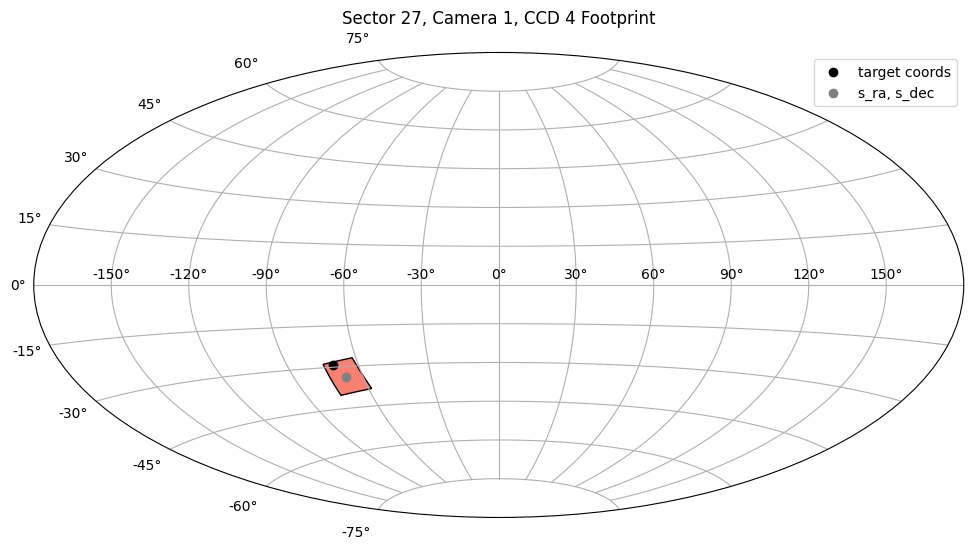

In [4]:
# Extract the polygon vertices, then store them in separate lists
polygon = obs['s_region'][0]
split = polygon.split(' ')
# Removing the "POLYGON" string
split.pop(0)
# Storing the RAs and Decs separately
ras, decs = split[::2], split[1::2]

# Now we convert our RAs/Decs into radians and wrap them around 180 degrees
coords = []
for ra, dec in zip(ras, decs):
    ra_rad, dec_rad = convert_coords(ra, dec)
    coords.append((ra_rad, dec_rad))

# We use Matplotlib's Path and PathPatch to plot the footprint of sector 27, camera 1, CCD 4
ax = plot_footprint(coords)

# Now let's plot our input target's RA, Dec on top of the footprint to see its relative position
target_ra, target_dec = coordinates.ra.degree, coordinates.dec.degree
target_coords = convert_coords(target_ra, target_dec)
ax.scatter(target_coords[0], target_coords[1], color='k', label='target coords')

# And lastly, let's plot the s_ra and s_dec coordinates to see what they represent
s_coords = convert_coords(obs['s_ra'][0], obs['s_dec'][0])
ax.scatter(s_coords[0], s_coords[1], color='grey', label='s_ra, s_dec')

ax.set_title('Sector 27, Camera 1, CCD 4 Footprint' + '\n' + ' ')
plt.legend()
plt.show()

The plot above shows the positioning of TIC 2527981 relative to sector 27, camera 1, CCD 4. You can see that it is more or less on the edge of this CCD, and not the center. Note also that the `s_ra` and `s_dec` fall exactly in the center of the CCD. 

From this observation we can now retrieve the corresponding TICA products (FFIs). Let's use the `get_product_list` method to retrieve these FFIs.

<div class="alert alert-block alert-info"><b>Note:</b> If you do not know which sectors contain your target, you should query for your target without the `sequence_number` filter to see what is available. However, the cutout functionality does not currently support making cross-sector cutouts, so FFI products from different sectors cannot be stacked into the same cube. Keep this in mind when retrieving the FFI products intended for your cube.</div>

In [5]:
products = Observations.get_product_list(obs['obsid'])
products

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level,filters
str8,str4,str5,str59,str4,str1,str95,str7,str1,str1,str1,str4,str1,str3,str64,int64,str8,str6,int64,str4
96582243,HLSP,image,hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img,FITS,D,mast:HLSP/tica/s0027/cam1-ccd4/hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img.fits,SCIENCE,--,--,--,TICA,1,N/A,hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img.fits,17795520,96814766,PUBLIC,4,TESS
96582244,HLSP,image,hlsp_tica_tess_ffi_s0027-o1-00118095-cam1-ccd4_tess_v01_img,FITS,D,mast:HLSP/tica/s0027/cam1-ccd4/hlsp_tica_tess_ffi_s0027-o1-00118095-cam1-ccd4_tess_v01_img.fits,SCIENCE,--,--,--,TICA,1,N/A,hlsp_tica_tess_ffi_s0027-o1-00118095-cam1-ccd4_tess_v01_img.fits,17795520,96814766,PUBLIC,4,TESS
96582245,HLSP,image,hlsp_tica_tess_ffi_s0027-o1-00117909-cam1-ccd4_tess_v01_img,FITS,D,mast:HLSP/tica/s0027/cam1-ccd4/hlsp_tica_tess_ffi_s0027-o1-00117909-cam1-ccd4_tess_v01_img.fits,SCIENCE,--,--,--,TICA,1,N/A,hlsp_tica_tess_ffi_s0027-o1-00117909-cam1-ccd4_tess_v01_img.fits,17795520,96814766,PUBLIC,4,TESS
96582255,HLSP,image,hlsp_tica_tess_ffi_s0027-o1-00117591-cam1-ccd4_tess_v01_img,FITS,D,mast:HLSP/tica/s0027/cam1-ccd4/hlsp_tica_tess_ffi_s0027-o1-00117591-cam1-ccd4_tess_v01_img.fits,SCIENCE,--,--,--,TICA,1,N/A,hlsp_tica_tess_ffi_s0027-o1-00117591-cam1-ccd4_tess_v01_img.fits,17795520,96814766,PUBLIC,4,TESS
96582257,HLSP,image,hlsp_tica_tess_ffi_s0027-o1-00117836-cam1-ccd4_tess_v01_img,FITS,D,mast:HLSP/tica/s0027/cam1-ccd4/hlsp_tica_tess_ffi_s0027-o1-00117836-cam1-ccd4_tess_v01_img.fits,SCIENCE,--,--,--,TICA,1,N/A,hlsp_tica_tess_ffi_s0027-o1-00117836-cam1-ccd4_tess_v01_img.fits,17795520,96814766,PUBLIC,4,TESS
96582258,HLSP,image,hlsp_tica_tess_ffi_s0027-o1-00118089-cam1-ccd4_tess_v01_img,FITS,D,mast:HLSP/tica/s0027/cam1-ccd4/hlsp_tica_tess_ffi_s0027-o1-00118089-cam1-ccd4_tess_v01_img.fits,SCIENCE,--,--,--,TICA,1,N/A,hlsp_tica_tess_ffi_s0027-o1-00118089-cam1-ccd4_tess_v01_img.fits,17795520,96814766,PUBLIC,4,TESS
96582259,HLSP,image,hlsp_tica_tess_ffi_s0027-o1-00117485-cam1-ccd4_tess_v01_img,FITS,D,mast:HLSP/tica/s0027/cam1-ccd4/hlsp_tica_tess_ffi_s0027-o1-00117485-cam1-ccd4_tess_v01_img.fits,SCIENCE,--,--,--,TICA,1,N/A,hlsp_tica_tess_ffi_s0027-o1-00117485-cam1-ccd4_tess_v01_img.fits,17795520,96814766,PUBLIC,4,TESS
96582260,HLSP,image,hlsp_tica_tess_ffi_s0027-o1-00116470-cam1-ccd4_tess_v01_img,FITS,D,mast:HLSP/tica/s0027/cam1-ccd4/hlsp_tica_tess_ffi_s0027-o1-00116470-cam1-ccd4_tess_v01_img.fits,SCIENCE,--,--,--,TICA,1,N/A,hlsp_tica_tess_ffi_s0027-o1-00116470-cam1-ccd4_tess_v01_img.fits,17795520,96814766,PUBLIC,4,TESS
96582282,HLSP,image,hlsp_tica_tess_ffi_s0027-o1-00117827-cam1-ccd4_tess_v01_img,FITS,D,mast:HLSP/tica/s0027/cam1-ccd4/hlsp_tica_tess_ffi_s0027-o1-00117827-cam1-ccd4_tess_v01_img.fits,SCIENCE,--,--,--,TICA,1,N/A,hlsp_tica_tess_ffi_s0027-o1-00117827-cam1-ccd4_tess_v01_img.fits,17795520,96814766,PUBLIC,4,TESS


### Downloading the FFIs

Now we are ready to download the products. Use the `download_products` call to download these locally to your machine. 

<div class="alert alert-block alert-info"><b>Note:</b> If you have many files, or a large download size, you should set the `curl_flag` option to `True`. This will generate a bash script that will download the products (via cURL) when executed. </div>

To save space in this example, we will only download the first 5 TICA FFIs.

In [6]:
manifest = Observations.download_products(products[:5], curl_flag=False)
manifest

INFO: Found cached file ./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img.fits with expected size 17795520. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00118095-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00118095-cam1-ccd4_tess_v01_img.fits with expected size 17795520. [astroquery.query]


INFO: Found cached file ./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117909-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117909-cam1-ccd4_tess_v01_img.fits with expected size 17795520. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117591-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117591-cam1-ccd4_tess_v01_img.fits with expected size 17795520. [astroquery.query]


INFO: Found cached file ./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117836-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117836-cam1-ccd4_tess_v01_img.fits with expected size 17795520. [astroquery.query]


Local Path,Status,Message,URL
str144,str8,object,object
./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img.fits,COMPLETE,None,None
./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00118095-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00118095-cam1-ccd4_tess_v01_img.fits,COMPLETE,None,None
./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117909-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117909-cam1-ccd4_tess_v01_img.fits,COMPLETE,None,None
./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117591-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117591-cam1-ccd4_tess_v01_img.fits,COMPLETE,None,None
./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117836-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117836-cam1-ccd4_tess_v01_img.fits,COMPLETE,None,None


### Inspecting the FFIs

Now that we have the TICA FFIs stored locally, let's do some quick plotting and inspection. We can use the `manifest` output from our download call above to get the list of our downloaded FFIs in their respective locations. Let's open up one of them and do some plotting and header inspection.

In [7]:
ffi = manifest['Local Path'][0]
print('FFI')
print(ffi)
print(' ')
print('HDU List')
print(fits.info(ffi))

FFI
./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img.fits
 
HDU List
Filename: ./mastDownload/HLSP/hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img/hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     181   (2136, 2078)   float32   
  1                1 BinTableHDU     20   989R x 4C   [K, E, E, I]   


None


Unlike the SPOC FFIs, the TICA FFIs have the science data stored in the Primary HDU of the FITS file. The BinTable HDU contains the list of all the reference sources used to derive the WCS solutions for the data. More information on this is available in the [TICA pipeline paper](https://ui.adsabs.harvard.edu/abs/2020RNAAS...4..251F/abstract), but let's move forward and retrieve the header information from the Primary HDU.

In [8]:
header = fits.getheader(ffi, 0)
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 2136                                                  
NAXIS2  =                 2078                                                  
EXTEND  =                    T                                                  
CRM_N   =                   10 / Window for CRM min/max rejection               
ORBIT_ID=                   61 / Orbit ID, not a physical orbit                 
ACS_MODE= 'FP      '           / Attitude Control System mode                   
SC_RA   =    326.8525352094406 / Predicted RA                                   
SC_DEC  =   -72.42645616046441 / Predicted Dec                                  
SC_ROLL =   -145.4939246174957 / Predicted roll                                 
SC_QUATX=           0.550150

The header information above contains important metadata like the CD matrix elements used for the WCS transformations, exposure time of the observation, size of the image, and so on. Now let's retrieve the science data from this Primary HDU and plot the sector 27 camera 1 CCD 4 field.

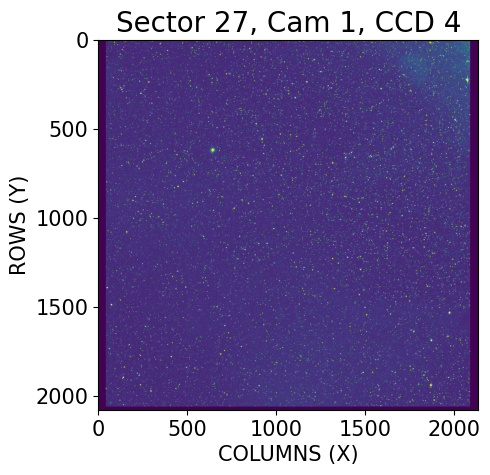

In [9]:
# Retrieve the data and some header metadata for labeling
data = fits.getdata(ffi, 0)
cam, ccd = header['CAMNUM'], header['CCDNUM']

# Plotting
plt.imshow(data, vmin=0, vmax=1000000)

# Labeling
plt.title(f'Sector 27, Cam {cam}, CCD {ccd}', fontsize=20)
plt.xlabel('COLUMNS (X)', fontsize=15)
plt.ylabel('ROWS (Y)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.show()

## Creating a Cube

Now that we have retrieved, downloaded, and inspected our TICA FFIs, it's time to make a cube out of them. To do this, we will call on astrocut's `TicaCubeFactory` class which contains all the functionality to stack the TICA FFIs into a cube as efficiently as possible and store all the FFIs' metadata in a binary table.

In [10]:
tica_cube_maker = TicaCubeFactory()

We will utilize the `manifest` output from our `download_products` call in the previous section to feed `TicaCubeFactory.make_cube` the batch of 5 TICA FFIs for the cube-making process. The `verbose` argument is set to `True` by default, which will print updates about the call, but you may change `verbose` to `False` if you so choose.

In [11]:
cube = tica_cube_maker.make_cube(manifest['Local Path'])

DEBUG: Using hlsp_tica_tess_ffi_s0027-o1-00117679-cam1-ccd4_tess_v01_img.fits to initialize the image header table. [cube_factory]


DEBUG: Cube will be made in 1 blocks of 2079 rows each. [cube_factory]


/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/astrocut/cube_factory.py:371: StringTruncateWarning: truncated right side string(s) longer than 8 character(s) during assignment
  self._info_table[kwd][i] = self._get_header_keyword(kwd, img_data, nulval)
DEBUG: Completed file 0 in 0.020 sec. [cube_factory]


DEBUG: Completed file 1 in 0.014 sec. [cube_factory]


/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/astrocut/cube_factory.py:371: StringTruncateWarning: truncated right side string(s) longer than 8 character(s) during assignment
  self._info_table[kwd][i] = self._get_header_keyword(kwd, img_data, nulval)
DEBUG: Completed file 2 in 0.013 sec. [cube_factory]


/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/astrocut/cube_factory.py:371: StringTruncateWarning: truncated right side string(s) longer than 8 character(s) during assignment
  self._info_table[kwd][i] = self._get_header_keyword(kwd, img_data, nulval)
DEBUG: Completed file 3 in 0.013 sec. [cube_factory]


/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/astrocut/cube_factory.py:371: StringTruncateWarning: truncated right side string(s) longer than 8 character(s) during assignment
  self._info_table[kwd][i] = self._get_header_keyword(kwd, img_data, nulval)
DEBUG: Completed file 4 in 0.013 sec. [cube_factory]


DEBUG: Completed block 1 of 1 [cube_factory]


DEBUG: Total time elapsed: 0.01 min [cube_factory]


The cube file is stored in your current working directory with the default name `img-cube.fits` if none is specified. Let's inspect the contents of the cube file:

In [12]:
fits.info(cube)

Filename: img-cube.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     182   ()      
  1                1 ImageHDU         9   (1, 5, 2136, 2078)   float32   
  2                1 BinTableHDU    550   5R x 182C   [J, J, J, J, J, J, J, J, 2A, D, D, D, D, D, D, D, D, D, D, D, D, J, J, J, J, J, J, J, D, J, J, J, J, 16A, D, D, D, D, 9A, 5A, D, 15A, 4A, 4A, D, D, D, D, D, D, D, D, 12A, 12A, D, D, D, D, J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, J, J, J, 16A, 8A, 49A, 64A]   


The structure for each cube file is the same for both TICA and SPOC. It consists of:

* **The Primary HDU**, which contains header information derived from the first FFI in the cube stack, as well as WCS information derived from the FFI in the middle of the cube stack.
* **The Image HDU**, which is the cube itself. The dimensions of the cube for this example is `(2, 5, 2136, 2078)` and can be explained as follows:
    * The 0th axis represents the science and error "layers", with the science arrays in index=0 and the error arrays in index=1. Because the TICA pipeline does not propagate errors, the error layer is empty for all the FFIs and should be ignored. 
    * The 1st axis represents the number of FFIs that went into the cube. For this example it is 5. Indexing this will pull out the 2D array of science data for a given FFI.
    * The 2nd axis represents the number of rows each FFI consists of.
    * The 3rd axis represents the number of columns each FFI consists of.
* **The BinTable HDU**, which contains the image header information for every FFI that went into the stack in the form of a table. Each column in the table is an image header keyword (for TICA it's the primary header keyword, since the TICA image lives in the primary HDU), and each row in the column is the corresponding value for that keyword for an FFI. 

For more information on the cube file structure, see the [cube file format section](https://astrocut.readthedocs.io/en/latest/astrocut/file_formats.html#cube-files) of the Astrocut documentation.

Before we move onto generating the cutouts, it's important to note that `CubeFactory` is distinct from `TicaCubeFactory`. Both classes are used to generate cubes, but `TicaCubeFactory` is specifically designed to generate TICA cubes, and `CubeFactory` is specifically designed to generate SPOC cubes. Any attempt at generating TICA cubes with `CubeFactory` or vice versa will be unsuccessful. See below for an example:

In [13]:
# This cell will give an error if you uncomment the lines below!

# from astrocut import CubeFactory
#spoc_cube_maker = CubeFactory()
#spoc_cube_maker.make_cube(manifest['Local Path'])

## Creating the Cutouts

Now that we have our cube we are able to generate cutouts of our region of interest. Unlike in the cube-making process, we have a single class for generating the cutouts from both SPOC or TICA cubes, `CutoutFactory`. To make the cutouts, we will call upon `CutoutFactory`'s  `cube_cut` and feed it the cube we just made, the coordinates for the center of our region of interest, which in this case is our object TIC 2527981, the cutout size for our region (in pixels), and lastly, the product type that was used for making our cube.

<div class="alert alert-block alert-info"><b>Note:</b> The call below may generate a "VerifyWarning: Card is too long, comment will be truncated." warning message, which can safely be ignored. </div>

In [14]:
cutout_maker = CutoutFactory()

cutout_file = cutout_maker.cube_cut(cube, coordinates=coordinates, cutout_size=25, product='TICA')
cutout_file

'img_289.097900_-29.337000_25x25_astrocut.fits'

Our cutout file is saved to our current working directory with the default name structured as follows:
`img_[RA]_[Dec]_[rows]x[cols]_astrocut.fits`

Let's inspect the HDU list of this file...

In [15]:
fits.info(cutout_file)

Filename: img_289.097900_-29.337000_25x25_astrocut.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY     1   PrimaryHDU      57   ()      
  1  PIXELS      1   BinTableHDU    142   5R x 11C   [D, J, 625J, 625E, 625E, 625E, 625E, J, E, E, 38A]   
  2  APERTURE    1   ImageHDU        82   (25, 25)   int32   


The structure for each cutout file is the same for both TICA and SPOC. It consists of: 
* **The Primary HDU**, which contains header information derived from the first FFI in the cube stack, as well as WCS information derived from the FFI in the middle of the cube stack.
* **The BinTable HDU**, which is a FITS table that stores the actual cutouts under the `FLUX` column, with each row being occupied by a single FFI cutout of the requested size.
* **The Image HDU**, which contains the aperture, or field of view, of the cutouts. This image is only useful for the moving targets feature on TESSCut, and should be blank if your target has a set of coordinates assigned to it.

For more information on the cutout file structure, see the [target pixel file format section](https://astrocut.readthedocs.io/en/latest/astrocut/file_formats.html#target-pixel-files) of the Astrocut documentation. For now let's take a closer look at the Primary HDU header:

In [16]:
cutout_header = fits.getheader(cutout_file, 0)
cutout_header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TICAVER = '0.2.1   '           / tica software version                          
EQUINOX =               2000.0                                                  
INSTRUME= 'TESS Photometer'                                                     
TELESCOP= 'TESS    '                                                            
CHECKSUM= '1gDG4ZAF1fAF1ZAF'   / HDU checksum updated 2025-12-18T19:19:15       
DATASUM = '0       '           / data unit checksum updated 2025-12-18T19:19:15 
ORIGIN  = 'STScI/MAST'                                                          
DATE    = '2025-12-18'         / FFI cube creation date                         
SECTOR  =  / Observing secto

As mentioned previously, the cutout files will have header information that is inherited from the first FFI and the middle FFI in the cube stack (just like the cube files), so most of these keywords should look familiar. However, there are some new header keywords in the cutout files that are added after processing:

In [17]:
print(cutout_header.cards['FFI_TYPE'])
print(cutout_header.cards['PROCVER'])

FFI_TYPE= 'TICA    '           / the FFI type used to make the cutouts          
PROCVER = '1.1.0   '           / software version                               


These keywords are intentionally added so that the cutout is formatted like a TESS target pixel file (TPF). Conveniently, this means you can use existing scripts on these cutout files without having to readapt them. Let's go ahead and plot one of the cutouts in our file:

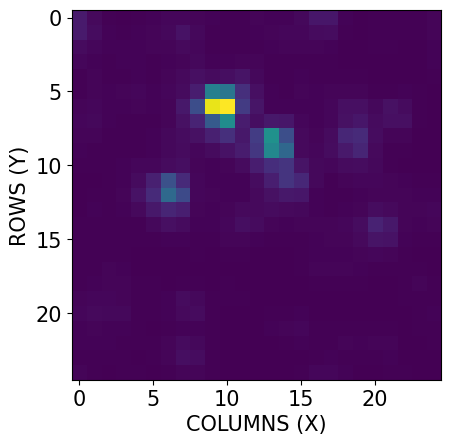

In [18]:
# Extracting the cutouts science data from the BinTable HDU
cutouts = fits.getdata(cutout_file)['FLUX']

# Plotting an arbitrary cutout from the FLUX column
plt.imshow(cutouts[3])

# Labeling
plt.xlabel('COLUMNS (X)', fontsize=15)
plt.ylabel('ROWS (Y)', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.show()

## Exercise: Generate Cutouts for TIC 2527981 Sector 27 SPOC Products

Let's now generate cutouts of our target from the SPOC products of the same observation, and use this as an opportunity to compare the FFI file structure differences between SPOC and TICA.

Perform the same `astroquery.mast.Observations` query, inspect the FFIs, generate the cube (remember that there are two cube-generating classes, `CubeFactory` and `TicaCubeFactory`), and generate the cutouts from the cube, in the cells below.

In [19]:
# Make a query for the correct observation using `astroquery.mast.Observations.query_criteria`

# Retrieve the products corresponding to this observations using `astroquery.mast.Observations.download_products`

# Inspect one of the FFIs with `matplotlib.pyplot`. Compare the HDU List between the SPOC FFI and one of the TICA FFIs
# and note the structural differences.

In [20]:
# Generate a cube with the SPOC FFIs.
# If you've stored the output from the `astroquery.mast.Observations.download_products` call above, 
# it's helpful to use the Local Path column as the CubeFactory input.

In [21]:
# Inspect the cube as you wish. Make a note of the cube size and ensure that the dimensions are as you expect.

In [22]:
# Generate the cutouts with the SPOC cube from above.

In [23]:
# Inspect the cutouts as you wish.

## Resources

The following is a list of resources that were referenced throughout the tutorial, as well as some additional references that you may find useful:

- [astrocut](https://astrocut.readthedocs.io/en/latest/astrocut/index.html) Documentation
- [astrocut](https://github.com/spacetelescope/astrocut) GitHub repository
- [astroquery.mast](https://astroquery.readthedocs.io/en/latest/mast/mast.html) Documentation
- The [TESSCut Service](https://mast.stsci.edu/tesscut/)
- The [TESSCut API Documentation](https://mast.stsci.edu/tesscut/docs/index.html)
- More information on the [TESS mission](https://archive.stsci.edu/missions-and-data/tess)
- More information on the [TICA HLSP](https://archive.stsci.edu/hlsp/tica)
- Publication on the [SPOC Pipeline](https://ui.adsabs.harvard.edu/abs/2016SPIE.9913E..3EJ/abstract)
- Publication on the [TICA Quicklook Pipeline](https://iopscience.iop.org/article/10.3847/2515-5172/abd63a)

## Citations

If you use any of astroquery's tools or astrocut for published research, please cite the
authors. Follow these links for more information about citing astroquery and astrocut:

* [Citing `astroquery`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)
* [Citing `astrocut`](https://ui.adsabs.harvard.edu/abs/2019ascl.soft05007B/abstract)

## About this Notebook
If you have comments or questions on this notebook, please contact us through the Archive Help Desk e-mail at `archive@stsci.edu`.

**Author(s):** Jenny V. Medina <br>
**Keyword(s):** Tutorial, TESS, TICA, SPOC, astroquery, astrocut, cutouts, ffi, tpf, tesscut <br>
**Last Updated:** Mar 2023 <br>
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 